# Grab-Microsoft Challenge 
## Traffic Management

- geohash6: geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa.(Examples:https://github.com/hkwi/python-geohash)
- day: the value indicates the sequential order and not a particular day of the month
- timestamp: start time of 15-minute intervals in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)
- demand: aggregated demand normalised to be in the range [0,1]
    
## Problem Statements:
- Which areas have high / low traffic demand?
- How does regional traffic demand change according to day / time?
- Forecast the travel demand for next 15min / 1hour and predict areas with high travel demand

### This is train LSTM model 

#### Import python library

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

# plot matplotlib graph
%matplotlib inline

#Import models from scikit learn module:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

import h5py
import sklearn.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model 

import pickle
import joblib


In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Define Variables

In [3]:
seed = 7
np.random.seed(seed)
modelname   = 'LSTM5'
batch_size  = 8192
no_of_epoch = 10
time_shift  = 5

# choose a number of time steps
n_steps_in, predict_next_no_of_output = 3, 2

### Define Function

In [37]:
def createModel(): 
    inputs  = Input(shape=(X_train1.shape[1],X_train1.shape[2]))
    y = LSTM(units=64, return_sequences=True, dropout=0.5, recurrent_dropout=0.2)(inputs)
    y = BatchNormalization()(y)
    y = LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.2)(y)
    y = BatchNormalization()(y)
    y = LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.3)(y)
    y = BatchNormalization()(y)
    y = LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.4)(y)
    y = BatchNormalization()(y)
    y = LSTM(64, return_sequences=True, dropout=0.5,recurrent_dropout=0.5)(y)
    y = BatchNormalization()(y)
    y = LSTM(32, dropout=0.5,recurrent_dropout=0.5)(y)
    y = BatchNormalization()(y)
    y = Dense(predict_next_no_of_output, activation='sigmoid')(y)
  
    model = Model(inputs=inputs,outputs=y)
    model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])
    return model

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

#### Reading from Preprocessed dataset

In [5]:
xls  = pd.ExcelFile('data/Dataset_featurefor_CNN.xlsx')
data = pd.read_excel(xls, 'TrafficMgmt')
data

,day,demand,hour,min,dow,lat,long
0,0.283333,0.020072,0.869565,0.000000,0.666667,0.533333,0.171429
1,0.150000,0.024721,0.608696,0.666667,0.500000,0.288889,0.200000
2,0.133333,0.102821,0.260870,0.333333,0.333333,0.644444,0.828571
3,0.516667,0.088755,0.217391,0.000000,0.666667,0.533333,0.428571
4,0.233333,0.074468,0.173913,0.000000,0.166667,0.288889,0.342857
...,...,...,...,...,...,...,...
1048570,0.083333,0.024022,0.347826,0.666667,1.000000,0.911111,0.771429
1048571,0.366667,0.005703,0.652174,0.666667,0.333333,0.111111,0.400000
1048572,0.683333,0.067131,0.652174,1.000000,0.000000,0.533333,0.200000
1048573,0.016667,0.151323,0.260870,0.666667,0.333333,0.711111,0.600000


In [6]:
predictor_var = ['day', 'hour', 'min', 'dow', 'lat', 'long']
outcome_var   = 'demand'

In [9]:
data = data[['day', 'hour', 'min', 'dow', 'lat', 'long','demand']]
data

,day,hour,min,dow,lat,long,demand
0,0.283333,0.869565,0.000000,0.666667,0.533333,0.171429,0.020072
1,0.150000,0.608696,0.666667,0.500000,0.288889,0.200000,0.024721
2,0.133333,0.260870,0.333333,0.333333,0.644444,0.828571,0.102821
3,0.516667,0.217391,0.000000,0.666667,0.533333,0.428571,0.088755
4,0.233333,0.173913,0.000000,0.166667,0.288889,0.342857,0.074468
...,...,...,...,...,...,...,...
1048570,0.083333,0.347826,0.666667,1.000000,0.911111,0.771429,0.024022
1048571,0.366667,0.652174,0.666667,0.333333,0.111111,0.400000,0.005703
1048572,0.683333,0.652174,1.000000,0.000000,0.533333,0.200000,0.067131
1048573,0.016667,0.260870,0.666667,0.333333,0.711111,0.600000,0.151323


#### Prepare training & test data
- Since this is a time series dataset, we can try using LSTM 
- and create a time series of say 20

In [16]:
dataset = data.to_numpy()
dataset

array([[0.28333333, 0.86956522, 0.        , ..., 0.53333333, 0.17142857,
        0.02007179],
       [0.15      , 0.60869565, 0.66666667, ..., 0.28888889, 0.2       ,
        0.02472097],
       [0.13333333, 0.26086957, 0.33333333, ..., 0.64444444, 0.82857143,
        0.10282096],
       ...,
       [0.68333333, 0.65217391, 1.        , ..., 0.53333333, 0.2       ,
        0.06713131],
       [0.01666667, 0.26086957, 0.66666667, ..., 0.71111111, 0.6       ,
        0.15132309],
       [0.06666667, 0.43478261, 1.        , ..., 0.68888889, 0.8       ,
        0.02600688]])

In [17]:
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, predict_next_no_of_output)
print(X.shape, y.shape)

(1048572, 3, 6) (1048572, 2)


In [18]:
# summarize the data
for i in range(3):
    print(X[i], y[i])

[[0.28333333 0.86956522 0.         0.66666667 0.53333333 0.17142857]
 [0.15       0.60869565 0.66666667 0.5        0.28888889 0.2       ]
 [0.13333333 0.26086957 0.33333333 0.33333333 0.64444444 0.82857143]] [0.10282096 0.0887548 ]
[[0.15       0.60869565 0.66666667 0.5        0.28888889 0.2       ]
 [0.13333333 0.26086957 0.33333333 0.33333333 0.64444444 0.82857143]
 [0.51666667 0.2173913  0.         0.66666667 0.53333333 0.42857143]] [0.0887548  0.07446839]
[[0.13333333 0.26086957 0.33333333 0.33333333 0.64444444 0.82857143]
 [0.51666667 0.2173913  0.         0.66666667 0.53333333 0.42857143]
 [0.23333333 0.17391304 0.         0.16666667 0.28888889 0.34285714]] [0.07446839 0.02384314]


In [19]:
X

array([[[0.28333333, 0.86956522, 0.        , 0.66666667, 0.53333333,
         0.17142857],
        [0.15      , 0.60869565, 0.66666667, 0.5       , 0.28888889,
         0.2       ],
        [0.13333333, 0.26086957, 0.33333333, 0.33333333, 0.64444444,
         0.82857143]],

       [[0.15      , 0.60869565, 0.66666667, 0.5       , 0.28888889,
         0.2       ],
        [0.13333333, 0.26086957, 0.33333333, 0.33333333, 0.64444444,
         0.82857143],
        [0.51666667, 0.2173913 , 0.        , 0.66666667, 0.53333333,
         0.42857143]],

       [[0.13333333, 0.26086957, 0.33333333, 0.33333333, 0.64444444,
         0.82857143],
        [0.51666667, 0.2173913 , 0.        , 0.66666667, 0.53333333,
         0.42857143],
        [0.23333333, 0.17391304, 0.        , 0.16666667, 0.28888889,
         0.34285714]],

       ...,

       [[0.8       , 0.08695652, 0.        , 0.        , 0.17777778,
         0.71428571],
        [0.08333333, 0.34782609, 0.66666667, 1.        , 0.91111111,
  

#### Train-test-val dataset split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,shuffle=False)

In [23]:
X_train.shape[1]

3

In [24]:
X_train.shape[2]

6

In [25]:
X_test.shape

(209715, 3, 6)

In [35]:
y_train.shape

(671085, 2)

In [27]:
X_train1 = np.asarray(X_train)
y_train1 = np.asarray(y_train)
X_test1  = np.asarray(X_test)
y_test1  = np.asarray(y_test)
X_val1   = np.asarray(X_val)
y_val1   = np.asarray(y_val)

In [28]:
X_val1.shape

(167772, 3, 6)

In [29]:
y_val1.shape

(167772, 2)

<h2><center>Create Model and test</center><h2>

<h3>LSTM<h3>

In [38]:
model = createModel()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 3, 64)             18176     
_________________________________________________________________
batch_normalization_6 (Batch (None, 3, 64)             256       
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 128)            98816     
_________________________________________________________________
batch_normalization_7 (Batch (None, 3, 128)            512       
_________________________________________________________________
lstm_8 (LSTM)                (None, 3, 256)            394240    
_________________________________________________________________
batch_normalization_8 (Batch (None, 3, 256)            1024

In [39]:
model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])

In [40]:
# Create checkpoints to save model during training and save training data into csv
# ‘monitor’ can be ‘val_acc’ or ‘val_loss’
# When set to ‘val_acc’, ‘mode’ must be ‘max’; when set to ‘val_loss’, ‘mode’ must be ‘min’

filepath       = modelname + ".hdf5"
checkpoint     = ModelCheckpoint(filepath, monitor='val_loss',verbose=0,save_best_only=True,mode='min') 
csv_logger     = CSVLogger(modelname + '.csv')
callbacks_list = [checkpoint,csv_logger]

In [41]:
# The line for training
hisgtory = model.fit(X_train1, 
                     y_train1, 
                     validation_data=(X_val1, y_val1), 
                     epochs=no_of_epoch, 
                     batch_size=batch_size,
                     shuffle=False,
                     callbacks=callbacks_list) 

Train on 671085 samples, validate on 167772 samples
Epoch 1/10
671085/671085 [==============================] - 22s 32us/sample - loss: 0.1751 - mse: 0.1751 - mae: 0.3764 - val_loss: 0.0998 - val_mse: 0.0998 - val_mae: 0.3021
Epoch 2/10
671085/671085 [==============================] - 8s 12us/sample - loss: 0.0705 - mse: 0.0705 - mae: 0.2363 - val_loss: 0.0359 - val_mse: 0.0359 - val_mae: 0.1604
Epoch 3/10
671085/671085 [==============================] - 8s 12us/sample - loss: 0.0301 - mse: 0.0301 - mae: 0.1334 - val_loss: 0.0264 - val_mse: 0.0264 - val_mae: 0.1143
Epoch 4/10
671085/671085 [==============================] - 8s 12us/sample - loss: 0.0259 - mse: 0.0259 - mae: 0.1076 - val_loss: 0.0253 - val_mse: 0.0253 - val_mae: 0.1018
Epoch 5/10
671085/671085 [==============================] - 8s 12us/sample - loss: 0.0254 - mse: 0.0254 - mae: 0.1007 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.0980
Epoch 6/10
671085/671085 [==============================] - 8s 12us/sample - loss:

### validation dataset test result

In [42]:
predicts = model.predict(X_val1)
print(mean_squared_error(y_val1,predicts))

0.025165718267102434


### Test dataset test result

In [43]:
predicted_value = model.predict(X_test1)
print(mean_squared_error(y_test1,predicted_value))

0.025285016152405672


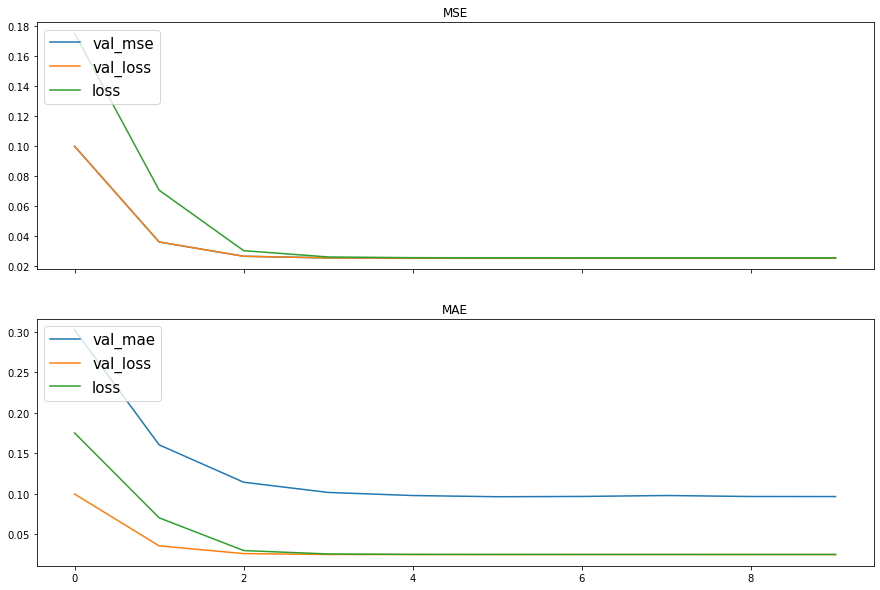

In [44]:
records     = pd.read_csv(modelname +'.csv')
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(records['val_mse'],label="val_mse")
plt.plot(records['val_loss'],label="val_loss")
plt.plot(records['loss'],label="loss")
plt.title('MSE',fontsize=12)
plt.legend(loc="upper left",fontsize=15)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_mae'],label="val_mae")
plt.plot(records['val_loss'],label="val_loss")
plt.plot(records['loss'],label="loss")
plt.title('MAE',fontsize=12)
plt.legend(loc="upper left",fontsize=15)

plt.show()



In [45]:
# Load your own trained model
model = load_model(filepath, compile = False)

In [1]:
# Data input sequence format :
test_data1  = [[18,20, 0, 4, -5.353088, 90.653687],
               [10,14,30, 3, -5.413513, 90.664673],
               [ 9, 6,15, 2, -5.325623, 90.906372]]
test_data2  = [[32, 5, 0, 4, -5.353088, 90.752563],
               [15, 4, 0, 1, -5.413513, 90.719604],
               [ 1,12,15, 1, -5.336609, 90.609741]]
test_data3  = [[25, 3,30, 4, -5.391541, 90.818481],
               [51,20,45, 2, -5.408020, 90.631714],
               [48, 6,15, 6, -5.364075, 90.763550]]
test_data4  = [[ 4,22,15, 4, -5.402527, 90.675659],
               [45, 9,15, 3, -5.402527, 90.917358],
               [52,11,45, 3, -5.364075, 90.664673]]
test_data5  = [[46,12,15, 4, -5.353088, 90.642700],
               [34,14,45, 6, -5.375061, 90.807495],
               [40, 2,30, 5, -5.424500, 90.785522]]
test_data6  = [[14,14,45, 0, -5.391541, 90.598755],
               [27, 3,30, 6, -5.320129, 90.785522],
               [ 6,23,45, 6, -5.358582, 90.752563]]

test_target1 = [[0.102821],[0.088755]]
test_target2 = [[0.023843],[0.007460]]
test_target3 = [[0.054170],[0.123463]]
test_target4 = [[0.359406],[0.514136]]
test_target5 = [[0.026409],[0.013998]]
test_target6 = [[0.029400],[0.057255]]

NameError: name 'pd' is not defined

In [ ]:
# Data input sequence format :
test_data1  = [[48,11,30, 6, -5.391541, 90.609741],
               [17.23,45, 3, -5.292664, 90.829468],
               [56,10, 0, 0, -5.413513, 90.774536]]
test_data2  = [[17,23,45, 3, -5.292664, 90.829468],
               [56,10, 0, 0, -5.413513, 90.774536],
               [52,11, 0, 3, -5.237732, 90.906372]]
test_data3  = [[56,10, 0, 0, -5.413513, 90.774536],
               [52,11, 0, 3, -5.237732, 90.906372],
               [57,18,30, 1, -5.292664, 90.829468]]
test_data4  = [[52,11, 0, 3, -5.237732, 90.906372],
               [57,18,30, 1, -5.292664, 90.829468],
               [21, 6, 0, 0, -5.292664, 90.796509 ]]
test_data5  = [[57,18,30, 1, -5.292664, 90.829468],
               [21, 6, 0, 0, -5.292664, 90.796509],
               [52,13, 0, 3, -5.397034, 90.796509]]
test_data6  = [[21, 6, 0, 0, -5.292664, 90.796509],
               [52,13, 0, 3, -5.397034, 90.796509],
               [53, 4,30, 4, -5.276184,90.675659]]

test_target1 = [[0.008772],[0.119240]]
test_target2 = [[0.119240],[0.033548]]
test_target3 = [[0.033548],[0.044277]]
test_target4 = [[0.044277],[0.072623]]
test_target5 = [[0.072623],[0.023049]]
test_target6 = [[0.023049],[0.090775]]

### Testing using 1 row of inference data

In [49]:
scaler_filename = "grab_msft_scaler.save"
scaler          = joblib.load(scaler_filename) 


C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


#### First set of testdata

In [62]:
Data_scaled = scaler.transform(test_data1)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target1))

Predicted value : [[0.10653497 0.10228226]]
Actual Value    : [[0.102821], [0.088755]]


#### Second set of testdata

In [65]:
Data_scaled = scaler.transform(test_data2)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target2))

Predicted value : [[0.10625625 0.10246835]]
Actual Value    : [[0.023843], [0.00746]]


In [66]:
Data_scaled = scaler.transform(test_data3)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target3))

Predicted value : [[0.10418733 0.10349084]]
Actual Value    : [[0.05417], [0.123463]]


In [67]:
Data_scaled = scaler.transform(test_data4)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target4))

Predicted value : [[0.10772736 0.10371813]]
Actual Value    : [[0.359406], [0.514136]]


In [68]:
Data_scaled = scaler.transform(test_data5)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target5))

Predicted value : [[0.10402867 0.10352363]]
Actual Value    : [[0.026409], [0.013998]]


In [69]:
Data_scaled = scaler.transform(test_data6)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target6))

Predicted value : [[0.10476458 0.10366043]]
Actual Value    : [[0.0294], [0.057255]]
